In [1]:
import sys
# append to path the folder that contains the analytic scanner
sys.path.append('../../GaiaLab/scan/analytic_scanner')

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

import quaternion
from agis import Agis
from agis import Calc_source
import agis_functions as af
import helpers as helpers
import analytic_plots as aplots

import numpy as np

import astropy.units as units
import matplotlib.pyplot as plt
import astropy.units as units

In [2]:
np.radians(0.5)

0.008726646259971648

In [108]:
const.S

4.035

In [3]:
t_init = 0 
t_end =  365*2
my_dt = 1/24 # [days]
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
scanner = Scanner()

In [4]:
class calc_src :
    """the data structure that is used for a calculated source"""
    def __init__(self,alpha,delta,varpi,muAlphaStar,muDelta):
        self.s_params = [alpha,delta,varpi,muAlphaStar,muDelta]
        self.mu_radial = 0.0

the agis.py code is not that simple, basic functionalities such as source solver are not obvious, below is a proposal for changes.

In [97]:
def compute_du_ds(p,q,r,q_l,t_l):
    """
    params p,q,r : the vectors defining the frame associated to a source position at reference epoch
    params q_l,t_l : the attitude at time t_l
    returns : du_ds_SRS
    """
    # Equation 73
    r.shape = (3, 1)  # reshapes r
    b_G = gaia.ephemeris_bcrs(t_l)
    tau = t_l - const.t_ep  # + np.dot(r, b_G) / const.c
    # Compute derivatives
    du_ds_CoMRS = [p, q, af.compute_du_dparallax(r, b_G), p*tau, q*tau]
    # Equation 72
    # should be changed to a pythonic map
    du_ds_SRS = []
    for derivative in du_ds_CoMRS:
        du_ds_SRS.append(ft.lmn_to_xyz(q_l, derivative))
    return np.array(du_ds_SRS)

def computeScanAngle(p0,q0,z):
    """
    Compute the scan direction angle theta = atan2(q0'z, -p0'z) 
    param p0 : local East (increasing alpha) 
    param q0 : local North (increasing delta if |delta_0|<90) 
    param z : unit vector z obtained from the attitude quaternion at the time of transit
    See equation (1) in LL-061 and equation (13)
    """
    return np.arctan2(q0@z,-p0@z)

def field_angle_offset(p0,q0,q):
    """simulate a close pair offset"""
    z = ft.xyz_to_lmn(q, np.array([0,0,1]))
    thetaScan = computeScanAngle(p0,q0,z)
    
    theta = 0.1
    r = 100 #mas
    modFactor = 1.15
    decayModFactor = 150
    dG = 0.1
    projectedSep = np.cos(theta-thetaScan)*r
    
    offset_mas = np.exp(-dG/modFactor) * projectedSep * np.exp( -np.abs(projectedSep)/decayModFactor )
    
    return offset_mas*units.mas.to(units.rad)
    

def compute_design_equation(true_source,calc_source,observation_times):
    """
    param true_source : the parameters of the true source
    param calc_source : the parameters of the estimated source
    param observation_times : scanner observation times
    returns : dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA(phi_obs, zeta_obs,phi_calc, zeta_calc)
    """
    alpha0 = calc_source.s_params[0]
    delta0 = calc_source.s_params[1]    
    p0, q0, r0 = ft.compute_pqr(alpha0, delta0)
    n_obs = len(observation_times)
    O_AL = np.zeros(n_obs)
    R_AL = np.zeros(n_obs)
    R_AC = np.zeros(n_obs)
    dR_ds_AL = np.zeros((n_obs, 5))
    dR_ds_AC = np.zeros((n_obs, 5))
    FA = []
    for j, t_l in enumerate(observation_times): 
        # one should use the 2 telescopes option for the residuals
        q_l = gaia.func_attitude(t_l)
        phi_obs, zeta_obs = af.observed_field_angles(true_source, q_l, gaia, t_l, True)
        phi_calc, zeta_calc = af.calculated_field_angles(calc_source, q_l, gaia, t_l, True)
        
        FA.append([phi_obs, zeta_obs,phi_calc, zeta_calc])
        
        O_AL[j] = field_angle_offset(p0,q0,q_l)
        R_AL[j] = (phi_obs-phi_calc) + O_AL[j]
        R_AC[j] = (zeta_obs-zeta_calc)
        
        # but not for the derivatives...
        phi_c, zeta_c = af.calculated_field_angles(calc_source, q_l, gaia, t_l, False)
        m, n, u = af.compute_mnu(phi_c, zeta_c)
        
        du_ds = compute_du_ds(p0,q0,r0,q_l,t_l)
        dR_ds_AL[j, :] = m @ du_ds.transpose() * helpers.sec(zeta_calc)
        dR_ds_AC[j, :] = n @ du_ds.transpose()
    return dR_ds_AL, dR_ds_AC, R_AL, R_AC, np.array(FA), np.array(O_AL)

def solve_AL(true_source,calc_source,observation_times):
    """
    perform one step of the source solver using only along scan observations
    """
    # get the design equation
    dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL = compute_design_equation(true_source,calc_source,observation_times)
    # build the normal equation
    N = dR_ds_AL.transpose() @ dR_ds_AL 
    rhs = dR_ds_AL.transpose() @ R_AL
    # solve the normal equation
    updates = np.linalg.solve(N,rhs)
    # update the calculated source parameters
    # take care of alpha
    calc_source.s_params[0] = calc_source.s_params[0] + updates[0] * np.cos(calc_source.s_params[1])
    calc_source.s_params[1:] = calc_source.s_params[1:] + updates[1:]

the source model might need some clarification

In [98]:
zero_color = lambda t: 0
LQSO = Source("LQSO", 180, 50, 0, 0, 0, 0, func_color=zero_color, mean_color=0 )

In [99]:
scanner.scan(gaia, LQSO, t_init, t_end)
scanner.compute_angles_eta_zeta(gaia, LQSO)
scanner_observation_times = scanner.obs_times

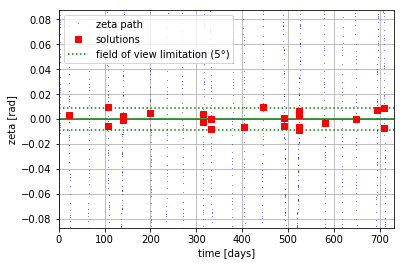

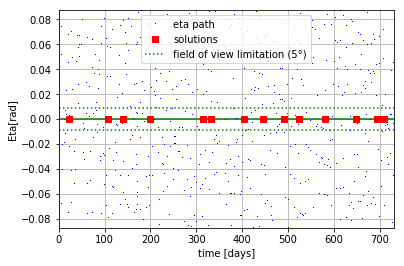

In [100]:
aplots.plot_field_angles(source=LQSO, sat=gaia, obs_times=scanner.obs_times, ti=t_init, tf=t_end, 
                  n=10000, limit=True, double_telescope=True);

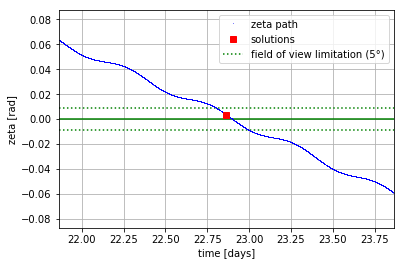

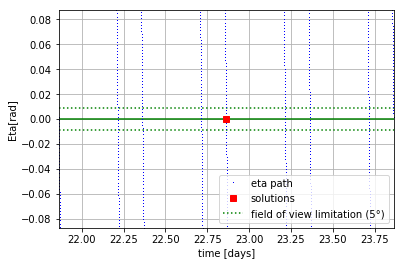

In [101]:
aplots.plot_field_angles(source=LQSO, sat=gaia, obs_times=scanner.obs_times, 
                         ti=scanner.obs_times[0]-1, tf=scanner.obs_times[0]+1, 
                  n=10000, limit=True, double_telescope=True);

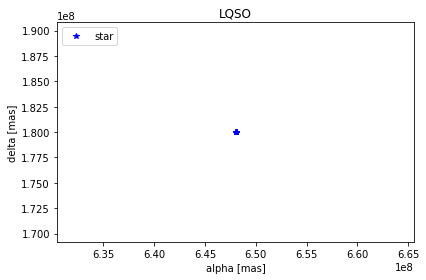

In [102]:
aplots.plot_star(source=LQSO, satellite=gaia, obs_times=scanner.obs_times);

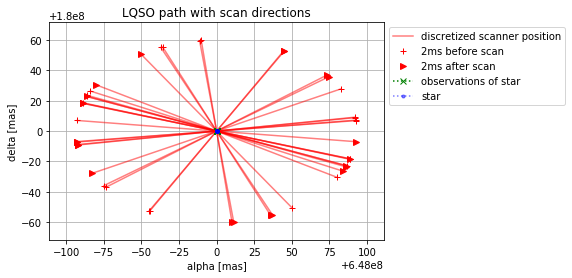

In [130]:
aplots.plot_star_trajectory_with_scans(sat=gaia, source=LQSO, obs_times=scanner.obs_times, 
                                      num_ms_for_snapshot=2);

In [104]:
def noise_calc_sources(s,noise = 1e-5):
    """
    add noise to source parameters
    """
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/10
    s.s_params[3] += s.s_params[3]*0.1
    s.s_params[4] += s.s_params[4]*0.1

The mode updating set to 'source' means that one used a non realistic attitude for each observation time based on the source position. The documentation should be updated to be clearer.

In [105]:
calc_s =  Calc_source(obs_times=scanner_observation_times, source=LQSO, mean_color=LQSO.mean_color)
noise_calc_sources(calc_s)
calc_s.s_params-LQSO.get_parameters()[:5]

array([1.e-05, 1.e-05, 0.e+00, 0.e+00, 0.e+00])

The field angles values computed in *compute_design_equation* can be used to visualised the source position in the sky as seen in the SRS reference frame associated to the satellite.

In [106]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL = compute_design_equation(LQSO,calc_s,scanner_observation_times)  

In [107]:
N = dR_ds_AL.transpose() @ dR_ds_AL

the units should clarified and the ones of the proper motion in rad/day are probably not the best choice

In [16]:
np.sqrt(np.diag(N))

array([   3.85569183,    2.85209315,    2.68721915, 1700.63203102,
       1348.39140418])

In [17]:
errors = np.sqrt(np.diag(np.linalg.inv(N)))
errors

array([0.6268297 , 0.89228688, 0.42254683, 0.00135565, 0.00189119])

In [18]:
units.rad.to(units.mas)

206264806.24709633

for the true source

In [19]:
np.sqrt(R_AL@R_AL)

3.448289598951604e-05

One can check that the solver is converging after 10 iterations of the source update.

In [20]:
for i in range(0,20):
    solve_AL(LQSO,calc_s,scanner_observation_times)
    calc_s.s_params-LQSO.get_parameters()[:5]

In [21]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL  = compute_design_equation(LQSO,calc_s,scanner_observation_times)  

In [22]:
np.sqrt(R_AL@R_AL)

9.110956496564744e-08

In [56]:
import constants as const
def toSource(calculated_Source,name):
    alpha0 = calculated_Source.s_params[0]*units.rad.to(units.deg)
    delta0 = calculated_Source.s_params[1]*units.rad.to(units.deg)
    varpi = calculated_Source.s_params[2]*units.rad.to(units.mas)
    # why do we use muAlpha?
    muAlpha = calculated_Source.s_params[3]*units.rad.to(units.mas) * const.days_per_year / np.cos(delta0)
    muDelta = calculated_Source.s_params[4]*units.rad.to(units.mas) * const.days_per_year
    print([alpha0, delta0, varpi, muAlpha, muDelta])
    return Source(name, alpha0, delta0, varpi, muAlpha, muDelta, 0, func_color=zero_color, mean_color=0 )

In [57]:
calc_s.s_params

array([ 3.14159264e+00,  8.72664896e-01,  1.85099154e-08,  7.74148791e-11,
       -2.06907911e-11])

In [58]:
LQSO_C = toSource(calc_s,"LQSO_C")

[179.9999989450315, 50.00001547881538, 3.8179441188862064, 6.039883831236312, -1.5577404390788052]


In [86]:
LQSO_C.topocentric_angles?

Signature: LQSO_C.topocentric_angles(satellite, t)
Docstring:
Calculates the angles of movement of the star from bcrs.

:param satellite: satellite object
:param t: [days]
:return: alpha, delta, delta alpha, delta delta [mas]
File:      ~/Documents/GitHub/GaiaLab/GaiaLab/scan/analytic_scanner/source.py
Type:      method


In [83]:
times = np.arange(t_init,t_end,30)
positions = []
for i, t in enumerate(times):
    alpha, delta, _, _ = LQSO_C.topocentric_angles(gaia, t)
    positions.append([alpha-LQSO_C.alpha,delta-LQSO_C.delta])
positions = np.array(positions)/const.rad_per_mas

In [84]:
positions[:,1]

array([ 0.34776004,  0.0876456 ,  0.56186154,  1.61332846,  2.93440771,
        4.14713985,  4.90182474,  4.96823076,  4.29564391,  3.0260953 ,
        1.45731639, -0.03491592, -1.09478969, -1.47926109, -1.12144574,
       -0.14806328,  1.1536137 ,  2.41068628,  3.26188951,  3.4518175 ,
        2.89753932,  1.7102286 ,  0.16616735, -1.36531439, -2.51816756])

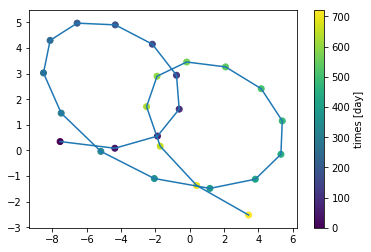

In [85]:
plt.plot(positions[:,0],positions[:,1])
plt.scatter(positions[:,0],positions[:,1],c=times)
plt.colorbar(label="times [day]")

there is a bug in aplots.plot_star_trajectory

# Plot the observation offset

In [193]:
def plot_sky_observations(sat, source, obs_times, offset_mas):
    positions = []
    for i, t in enumerate(obs_times):
        # scan position
        half_interval = 1 * 1/24/60/60/1000 # 1ms
        scan_position = []
        for ti in np.linspace(t-half_interval, t+half_interval, num=3):
            my_a,my_d = ft.vector_to_alpha_delta(aplots.get_obs_in_CoMRS(source, sat, ti))
            scan_position.append([my_a-source.alpha,my_d-source.delta])
            #vto = ft.vector_to_alpha_delta(aplots.get_obs_in_CoMRS(source, sat, t + offset_day))
        scan_position = np.array(scan_position)/const.rad_per_mas
        plt.plot(scan_position[:,0], scan_position[:,1], 'r-', alpha=0.3)
        
    offset_position = []
    for i, t in enumerate(obs_times):
        # offset
        offset_day = offset_mas[i]/sat.wz
        my_a,my_d = ft.vector_to_alpha_delta(aplots.get_obs_in_CoMRS(source, sat, t+offset_day))
        offset_position.append([my_a-source.alpha,my_d-source.delta])
    offset_position = np.array(offset_position)/const.rad_per_mas
    plt.scatter(offset_position[:,0],offset_position[:,1],c = obs_times,label="observation offset")
    plt.colorbar(label="observation time [day]")
    plt.legend()
    plt.grid()
    plt.xlabel("alpha - alpha0 [mas]")
    plt.ylabel("delta - delta0 [mas]")

In [194]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL = compute_design_equation(LQSO,calc_s,scanner_observation_times)  

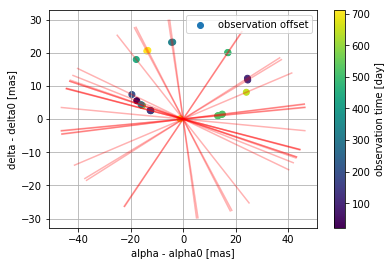

In [195]:
plot_sky_observations(gaia,LQSO,scanner.obs_times,O_AL)
